# 18. Advanced Time Series Topics

:::{important} Learning Objectives
:class: dropdown
By the end of this chapter, you should be able to:

**18.1** Estimate and interpret infinite distributed lag models (geometric and rational distributed lags).

**18.2** Test for unit roots using the Augmented Dickey-Fuller (ADF) test.

**18.3** Understand spurious regression and why non-stationary series can produce misleading results.

**18.4** Estimate cointegration relationships and error correction models for long-run equilibria.

**18.5** Forecast time series using various models and evaluate forecast accuracy.

**18.6** Apply event study methods with control groups for policy evaluation.
:::

Advanced time series econometrics addresses the challenges posed by non-stationary processes, long-run equilibrium relationships, and dynamic adjustment mechanisms in economic data. This chapter develops sophisticated methods for modeling infinite distributed lag structures, testing for unit roots and spurious relationships, estimating cointegrating vectors and error correction models, conducting forecasts with accuracy evaluation, and implementing event studies that combine time series and cross-sectional variation for policy analysis.

The development proceeds hierarchically through increasingly complex dynamic specifications. We begin with infinite distributed lag models including geometric and rational distributed lag specifications that capture persistent effects of explanatory variables (Section 18.1), develop unit root tests particularly the Augmented Dickey-Fuller (ADF) test for detecting non-stationarity in time series (Section 18.2), examine spurious regression problems that arise when trending variables are inappropriately analyzed using standard methods (Section 18.3), introduce cointegration as the concept of long-run equilibrium relationships between non-stationary variables and develop error correction models (ECMs) that incorporate both short-run dynamics and long-run equilibrium adjustments (Section 18.4), present forecasting methods including AR, VAR, and ADL models with evaluation of forecast accuracy using mean squared forecast error (Section 18.5), and conclude with event study methods combining difference-in-differences with time series controls for policy evaluation (Section 18.6). Throughout, we implement methods using Python's statsmodels library and demonstrate applications to macroeconomic relationships, financial markets, exchange rate dynamics, and monetary policy analysis.

In [1]:
# %pip install matplotlib numpy pandas statsmodels wooldridge scipy -q

In [2]:
# Import required libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import wooldridge as wool
from IPython.display import display
from scipy import stats
from statsmodels.tsa.stattools import adfuller, coint

# Set plotting style
sns.set_style("whitegrid")
sns.set_palette("husl")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["font.size"] = 11
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12

## 18.1 Infinite Distributed Lag Models

An **infinite distributed lag (IDL)** model allows current $y$ to depend on **all past values** of $x$:

$$ y_t = \alpha + \beta_0 x_t + \beta_1 x_{t-1} + \beta_2 x_{t-2} + \cdots + u_t $$

**Problem**: Infinite parameters to estimate!

**Solution**: Impose **structure** on how $\beta_j$ decays as $j$ increases.

### Geometric Distributed Lag (Koyck Transformation)

Assume coefficients decay **geometrically**:

$$ \beta_j = \beta_0 \rho^j, \quad 0 < \rho < 1 $$

This gives:

$$ y_t = \alpha + \beta_0(x_t + \rho x_{t-1} + \rho^2 x_{t-2} + \cdots) + u_t $$

**Key insight**: Lag $y_t$ by one period and multiply by $\rho$:

$$ \rho y_{t-1} = \rho \alpha + \beta_0 \rho(x_{t-1} + \rho x_{t-2} + \cdots) + \rho u_{t-1} $$

Subtract from original equation:

$$ y_t - \rho y_{t-1} = \alpha(1-\rho) + \beta_0 x_t + (u_t - \rho u_{t-1}) $$

Rearrange to get the **Koyck model**:

$$ y_t = \gamma_0 + \gamma_1 y_{t-1} + \beta_0 x_t + v_t $$

where:
- $\gamma_0 = \alpha(1-\rho)$
- $\gamma_1 = \rho$
- $v_t = u_t - \rho u_{t-1}$ (MA(1) error)

**Advantages**:
- Estimable with OLS (only 3 parameters!)
- Captures long-run effects through lagged dependent variable

**Disadvantages**:
- $v_t$ is serially correlated (MA(1))
- Restrictive assumption (geometric decay)

### Long-Run Propensity (LRP)

The **long-run propensity** measures the total cumulative effect of a permanent change in $x$:

$$ LRP = \beta_0 + \beta_1 + \beta_2 + \cdots = \frac{\beta_0}{1 - \rho} = \frac{\beta_0}{1 - \gamma_1} $$

**Interpretation**: If $x$ increases by 1 unit permanently, $y$ increases by $LRP$ units in the long run.

### Rational Distributed Lag

A more flexible alternative allows for **non-monotonic** lag patterns:

$$ y_t = \alpha + \beta_0 x_t + \beta_1 x_{t-1} + \beta_2 x_{t-2} + \cdots + u_t $$

With $\beta_j = (\beta_0 + \beta_1 \rho^{j-1}) \rho^j$ for $j \geq 1$.

After Koyck-type transformation:

$$ y_t = \gamma_0 + \gamma_1 y_{t-1} + \beta_0 x_t + \delta_1 x_{t-1} + v_t $$

This allows the impact to initially increase or decrease before decaying geometrically.

### Example 18.1: Housing Investment and Prices

In [3]:
# Load housing investment data
hseinv = wool.data("hseinv")

print("18.1 INFINITE DISTRIBUTED LAG MODELS")
print("=" * 70)
print("\nEXAMPLE: Housing investment and real housing prices")

print(f"\nTotal observations: {len(hseinv)}")
print("Time period: 1947-1988 (annual data)")

print("\nVARIABLES:")
print("  invpc  = real per capita housing investment")
print("  price  = real housing price index")
print("  linvpc = log(invpc)")
print("  gprice = growth rate of real housing prices")

# Create detrended and lagged variables
hseinv["linvpc_det"] = sm.tsa.tsatools.detrend(hseinv["linvpc"])
hseinv["gprice_lag1"] = hseinv["gprice"].shift(1)
hseinv["linvpc_det_lag1"] = hseinv["linvpc_det"].shift(1)

print("\nQUESTION: How does housing price growth affect investment?")
print("  - Immediate effect (beta_0)")
print("  - Long-run effect (LRP)")

# Summary statistics
key_vars = ["invpc", "price", "linvpc", "gprice"]
display(hseinv[key_vars].describe().round(4))

18.1 INFINITE DISTRIBUTED LAG MODELS

EXAMPLE: Housing investment and real housing prices

Total observations: 42
Time period: 1947-1988 (annual data)

VARIABLES:
  invpc  = real per capita housing investment
  price  = real housing price index
  linvpc = log(invpc)
  gprice = growth rate of real housing prices

QUESTION: How does housing price growth affect investment?
  - Immediate effect (beta_0)
  - Long-run effect (LRP)


,invpc,price,linvpc,gprice
count,42.0000,42.0000,42.0000,41.0000
mean,0.5213,0.9126,-0.6662,0.0045
std,0.0927,0.0592,0.1725,0.0199
min,0.3642,0.8190,-1.0101,-0.0366
25%,0.4541,0.8712,-0.7894,-0.0078
50%,0.4947,0.8855,-0.7038,0.0047
75%,0.5917,0.9721,-0.5250,0.0138
max,0.7034,1.0432,-0.3518,0.0545


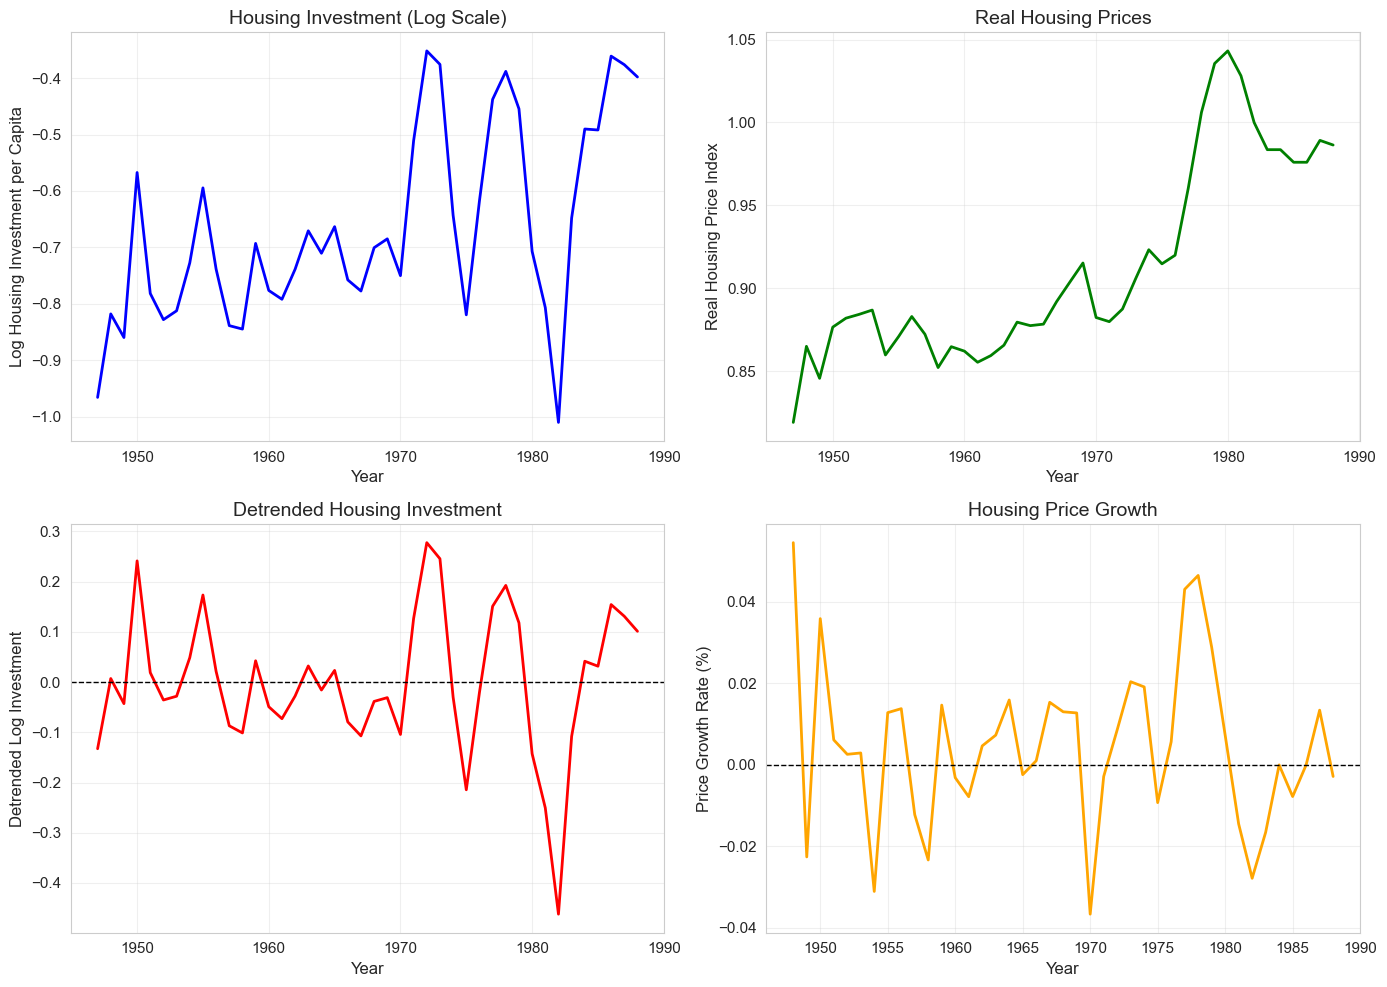


OBSERVATIONS:
YES Both investment and prices trend upward over time
YES Detrending removes long-run growth pattern
YES Price growth is volatile with cyclical patterns


In [4]:
# Visualize the data
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Panel A: Housing investment (log)
axes[0, 0].plot(hseinv["year"], hseinv["linvpc"], "b-", linewidth=2)
axes[0, 0].set_xlabel("Year")
axes[0, 0].set_ylabel("Log Housing Investment per Capita")
axes[0, 0].set_title("Housing Investment (Log Scale)")
axes[0, 0].grid(True, alpha=0.3)

# Panel B: Housing prices
axes[0, 1].plot(hseinv["year"], hseinv["price"], "g-", linewidth=2)
axes[0, 1].set_xlabel("Year")
axes[0, 1].set_ylabel("Real Housing Price Index")
axes[0, 1].set_title("Real Housing Prices")
axes[0, 1].grid(True, alpha=0.3)

# Panel C: Detrended log investment
axes[1, 0].plot(hseinv["year"], hseinv["linvpc_det"], "r-", linewidth=2)
axes[1, 0].axhline(y=0, color="black", linestyle="--", linewidth=1)
axes[1, 0].set_xlabel("Year")
axes[1, 0].set_ylabel("Detrended Log Investment")
axes[1, 0].set_title("Detrended Housing Investment")
axes[1, 0].grid(True, alpha=0.3)

# Panel D: Price growth
axes[1, 1].plot(hseinv["year"], hseinv["gprice"], "orange", linewidth=2)
axes[1, 1].axhline(y=0, color="black", linestyle="--", linewidth=1)
axes[1, 1].set_xlabel("Year")
axes[1, 1].set_ylabel("Price Growth Rate (%)")
axes[1, 1].set_title("Housing Price Growth")
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nOBSERVATIONS:")
print("YES Both investment and prices trend upward over time")
print("YES Detrending removes long-run growth pattern")
print("YES Price growth is volatile with cyclical patterns")

In [5]:
# KOYCK GEOMETRIC DISTRIBUTED LAG
print("\nKOYCK MODEL (Geometric Distributed Lag)")
print("=" * 70)
print("Model: y_t = gamma_0 + gamma_1*y_{t-1} + beta_0*x_t + v_t")
print("where y = detrended log investment, x = price growth")

koyck = smf.ols(
    formula="linvpc_det ~ linvpc_det_lag1 + gprice",
    data=hseinv,
).fit()

table_koyck = pd.DataFrame(
    {
        "Coefficient": koyck.params,
        "Std. Error": koyck.bse,
        "t-statistic": koyck.tvalues,
        "p-value": koyck.pvalues,
    },
)

display(table_koyck.round(4))

print(f"\nR-squared: {koyck.rsquared:.4f}")
print(f"Observations: {koyck.nobs:.0f}")

print("\nINTERPRETATION:")
beta_0 = koyck.params["gprice"]
rho = koyck.params["linvpc_det_lag1"]

print(f"  beta_0 (immediate effect): {beta_0:.4f}")
print(
    f"    -> 1 percentage point increase in price growth -> {100 * beta_0:.2f}% immediate increase in investment"
)

print(f"\n  rho (persistence): {rho:.4f}")
print(f"    -> Each period, {100 * rho:.1f}% of previous period's effect carries over")

# Long-Run Propensity
lrp_koyck = beta_0 / (1 - rho)
print(f"\n  LRP (long-run effect): {lrp_koyck:.4f}")
print(
    f"    -> 1 percentage point permanent increase in price growth -> {100 * lrp_koyck:.2f}% long-run increase in investment"
)
print(f"    -> LRP = beta_0/(1-rho) = {beta_0:.4f}/(1-{rho:.4f}) = {lrp_koyck:.4f}")


KOYCK MODEL (Geometric Distributed Lag)
Model: y_t = gamma_0 + gamma_1*y_{t-1} + beta_0*x_t + v_t
where y = detrended log investment, x = price growth


,Coefficient,Std. Error,t-statistic,p-value
Intercept,-0.0100,0.0179,-0.5561,0.5814
linvpc_det_lag1,0.3399,0.1316,2.5831,0.0138
gprice,3.0948,0.9333,3.3159,0.0020



R-squared: 0.4067
Observations: 41

INTERPRETATION:
  beta_0 (immediate effect): 3.0948
    -> 1 percentage point increase in price growth -> 309.48% immediate increase in investment

  rho (persistence): 0.3399
    -> Each period, 34.0% of previous period's effect carries over

  LRP (long-run effect): 4.6884
    -> 1 percentage point permanent increase in price growth -> 468.84% long-run increase in investment
    -> LRP = beta_0/(1-rho) = 3.0948/(1-0.3399) = 4.6884


In [6]:
# RATIONAL DISTRIBUTED LAG
print("\n\nRATIONAL DISTRIBUTED LAG")
print("=" * 70)
print("Model: y_t = gamma_0 + gamma_1*y_{t-1} + beta_0*x_t + delta_1*x_{t-1} + v_t")
print("More flexible: allows non-monotonic lag pattern")

rational = smf.ols(
    formula="linvpc_det ~ linvpc_det_lag1 + gprice + gprice_lag1",
    data=hseinv,
).fit()

table_rational = pd.DataFrame(
    {
        "Coefficient": rational.params,
        "Std. Error": rational.bse,
        "t-statistic": rational.tvalues,
        "p-value": rational.pvalues,
    },
)

display(table_rational.round(4))

print(f"\nR-squared: {rational.rsquared:.4f}")
print(f"Observations: {rational.nobs:.0f}")

print("\nINTERPRETATION:")
beta_0_rat = rational.params["gprice"]
delta_1 = rational.params["gprice_lag1"]
rho_rat = rational.params["linvpc_det_lag1"]

print(f"  beta_0 (contemporaneous effect): {beta_0_rat:.4f}")
print(f"  delta_1 (one-period lag effect): {delta_1:.4f}")
print(f"  rho (persistence): {rho_rat:.4f}")

# Long-Run Propensity for rational DL
lrp_rational = (beta_0_rat + delta_1) / (1 - rho_rat)
print(f"\n  LRP (long-run effect): {lrp_rational:.4f}")
print(
    f"    -> LRP = (beta_0 + delta_1)/(1-rho) = ({beta_0_rat:.4f} + {delta_1:.4f})/(1-{rho_rat:.4f}) = {lrp_rational:.4f}"
)

if delta_1 < 0:
    print("\n  YES Negative lagged effect: price growth has smaller impact over time")
else:
    print("\n  YES Positive lagged effect: price growth has amplified impact initially")



RATIONAL DISTRIBUTED LAG
Model: y_t = gamma_0 + gamma_1*y_{t-1} + beta_0*x_t + delta_1*x_{t-1} + v_t
More flexible: allows non-monotonic lag pattern


,Coefficient,Std. Error,t-statistic,p-value
Intercept,0.0059,0.0169,0.3466,0.7309
linvpc_det_lag1,0.5472,0.1517,3.6076,0.0009
gprice,3.2564,0.9703,3.3559,0.0019
gprice_lag1,-2.9363,0.9732,-3.0172,0.0047



R-squared: 0.5420
Observations: 40

INTERPRETATION:
  beta_0 (contemporaneous effect): 3.2564
  delta_1 (one-period lag effect): -2.9363
  rho (persistence): 0.5472

  LRP (long-run effect): 0.7067
    -> LRP = (beta_0 + delta_1)/(1-rho) = (3.2564 + -2.9363)/(1-0.5472) = 0.7067

  YES Negative lagged effect: price growth has smaller impact over time


In [7]:
# Compare the two models
print("\n\nCOMPARISON: KOYCK vs RATIONAL DISTRIBUTED LAG")
print("=" * 70)

comparison = pd.DataFrame(
    {
        "Koyck": [
            koyck.params["gprice"],
            np.nan,
            koyck.params["linvpc_det_lag1"],
            lrp_koyck,
            koyck.rsquared,
        ],
        "Rational": [
            rational.params["gprice"],
            rational.params["gprice_lag1"],
            rational.params["linvpc_det_lag1"],
            lrp_rational,
            rational.rsquared,
        ],
    },
    index=["beta_0 (immediate)", "delta_1 (lagged x)", "rho (lagged y)", "LRP", "R^2"],
)

display(comparison.round(4))

print("\nKEY INSIGHTS:")
print("1. Both models show positive immediate effect of price growth on investment")
print("2. Rational DL has slightly better fit (higher R^2)")
print(f"3. LRP is larger in Koyck ({lrp_koyck:.4f}) than Rational ({lrp_rational:.4f})")
print("4. Rational DL shows negative lagged effect -> initial enthusiasm fades")

print("\nCHOICE OF MODEL:")
if rational.rsquared > koyck.rsquared + 0.01:
    print("YES Rational DL preferred: better fit, more flexible")
else:
    print("YES Koyck preferred: simpler, similar fit")



COMPARISON: KOYCK vs RATIONAL DISTRIBUTED LAG


,Koyck,Rational
beta_0 (immediate),3.0948,3.2564
delta_1 (lagged x),NaN,-2.9363
rho (lagged y),0.3399,0.5472
LRP,4.6884,0.7067
R^2,0.4067,0.5420



KEY INSIGHTS:
1. Both models show positive immediate effect of price growth on investment
2. Rational DL has slightly better fit (higher R^2)
3. LRP is larger in Koyck (4.6884) than Rational (0.7067)
4. Rational DL shows negative lagged effect -> initial enthusiasm fades

CHOICE OF MODEL:
YES Rational DL preferred: better fit, more flexible


## 18.2 Testing for Unit Roots

A time series has a **unit root** if it follows a **random walk**:

$$ y_t = y_{t-1} + u_t $$

where $u_t$ is stationary. This means:
- $y_t$ is **non-stationary** (variance grows over time)
- Shocks have **permanent effects** (no mean reversion)
- Standard inference breaks down (t-statistics don't follow t-distribution)

### AR(1) Model

Consider the general AR(1):

$$ y_t = \rho y_{t-1} + u_t $$

Three cases:
1. $|\rho| < 1$: **Stationary** (mean-reverting)
2. $\rho = 1$: **Unit root** (random walk, non-stationary)
3. $|\rho| > 1$: **Explosive** (diverges)

### Dickey-Fuller Test

To test for a unit root:

**Null hypothesis**: $H_0: \rho = 1$ (unit root, non-stationary)
**Alternative**: $H_1: \rho < 1$ (stationary)

Subtract $y_{t-1}$ from both sides:

$$ \Delta y_t = (\rho - 1) y_{t-1} + u_t = \theta y_{t-1} + u_t $$

where $\theta = \rho - 1$.

**Test**: $H_0: \theta = 0$ vs $H_1: \theta < 0$

**Problem**: Under $H_0$, the t-statistic does NOT follow a t-distribution!

**Solution**: Use **Dickey-Fuller critical values** (more negative than t-distribution).

### Augmented Dickey-Fuller (ADF) Test

If $u_t$ is serially correlated, add lags of $\Delta y_t$:

$$ \Delta y_t = \alpha + \theta y_{t-1} + \gamma_1 \Delta y_{t-1} + \cdots + \gamma_p \Delta y_{t-p} + u_t $$

This is the **ADF test**.

**Three specifications**:
1. **No constant, no trend**: $\Delta y_t = \theta y_{t-1} + \cdots$
2. **With constant**: $\Delta y_t = \alpha + \theta y_{t-1} + \cdots$
3. **With constant and trend**: $\Delta y_t = \alpha + \beta t + \theta y_{t-1} + \cdots$

**Decision rule**:
- If ADF statistic < critical value -> **Reject $H_0$** (stationary)
- If ADF statistic > critical value -> **Fail to reject $H_0$** (unit root)

### Example 18.4: Unit Root Test for GDP

In [8]:
# Load inventory data
inven = wool.data("inven")
inven["lgdp"] = np.log(inven["gdp"])

print("\n18.2 TESTING FOR UNIT ROOTS")
print("=" * 70)
print("\nEXAMPLE: Is log GDP stationary or does it have a unit root?")

print(f"\nTotal observations: {len(inven)}")
print("Time period: 1959Q1-2000Q4 (quarterly data)")

print("\nVARIABLE:")
print("  gdp  = US real GDP")
print("  lgdp = log(GDP)")

print("\nQUESTION: Does log GDP have a unit root?")
print("  H_0: Unit root (non-stationary, random walk)")
print("  H_1: Stationary (mean-reverting)")

# Summary statistics
display(inven[["gdp", "lgdp"]].describe().round(4))


18.2 TESTING FOR UNIT ROOTS

EXAMPLE: Is log GDP stationary or does it have a unit root?

Total observations: 37
Time period: 1959Q1-2000Q4 (quarterly data)

VARIABLE:
  gdp  = US real GDP
  lgdp = log(GDP)

QUESTION: Does log GDP have a unit root?
  H_0: Unit root (non-stationary, random walk)
  H_1: Stationary (mean-reverting)


,gdp,lgdp
count,37.0000,37.0000
mean,4336.5865,8.3226
std,1373.6251,0.3345
min,2212.3000,7.7018
25%,3288.6001,8.0982
50%,4279.2998,8.3615
75%,5489.8999,8.6107
max,6742.8999,8.8162


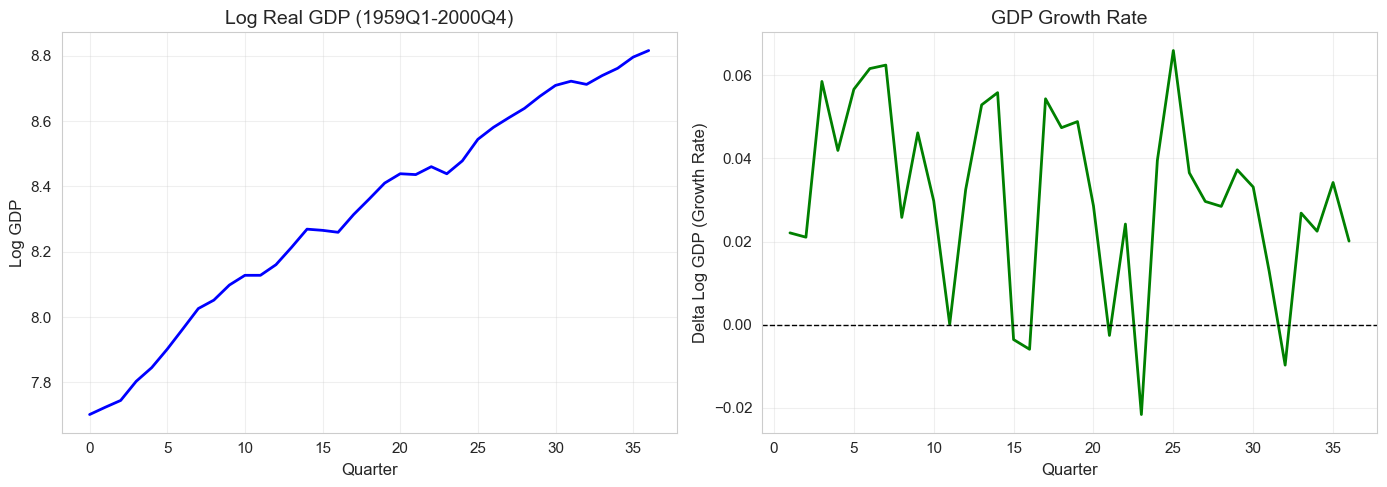


VISUAL INSPECTION:
YES Log GDP trends strongly upward -> suggests non-stationarity
YES Growth rate fluctuates around constant mean -> suggests stationarity
-> Need formal test to confirm!


In [9]:
# Visualize log GDP
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Panel A: Log GDP level
axes[0].plot(inven.index, inven["lgdp"], "b-", linewidth=2)
axes[0].set_xlabel("Quarter")
axes[0].set_ylabel("Log GDP")
axes[0].set_title("Log Real GDP (1959Q1-2000Q4)")
axes[0].grid(True, alpha=0.3)

# Panel B: First difference of log GDP (growth rate)
inven["dlgdp"] = inven["lgdp"].diff()
axes[1].plot(inven.index, inven["dlgdp"], "g-", linewidth=2)
axes[1].axhline(y=0, color="black", linestyle="--", linewidth=1)
axes[1].set_xlabel("Quarter")
axes[1].set_ylabel("Delta Log GDP (Growth Rate)")
axes[1].set_title("GDP Growth Rate")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nVISUAL INSPECTION:")
print("YES Log GDP trends strongly upward -> suggests non-stationarity")
print("YES Growth rate fluctuates around constant mean -> suggests stationarity")
print("-> Need formal test to confirm!")

In [10]:
# AUGMENTED DICKEY-FULLER TEST
print("\n\nAUGMENTED DICKEY-FULLER (ADF) TEST")
print("=" * 70)
print("Test: H_0: theta = 0 (unit root) vs H_1: theta < 0 (stationary)")
print("Model: Deltay_t = alpha + beta*t + theta*y_{t-1} + gamma_1*Deltay_{t-1} + u_t")
print("       (with constant and trend)")

# Perform ADF test with constant and trend
adf_results = adfuller(
    inven["lgdp"].dropna(),
    maxlag=1,
    regression="ct",  # constant and trend
    autolag=None,
)

# Extract results
adf_stat = adf_results[0]
adf_pval = adf_results[1]
adf_usedlag = adf_results[2]
adf_crit = adf_results[4]

print(f"\nADF statistic: {adf_stat:.4f}")
print(f"p-value: {adf_pval:.4f}")
print(f"Lags used: {adf_usedlag}")
print("Critical values:")
print(f"  1%: {adf_crit['1%']:.4f}")
print(f"  5%: {adf_crit['5%']:.4f}")
print(f"  10%: {adf_crit['10%']:.4f}")

print("\nADF REGRESSION OUTPUT:")
print(f"ADF test statistic: {adf_stat:.4f}")
print(f"p-value: {adf_pval:.4f}")
print(f"Lags used: {adf_usedlag}")

print("\nCRITICAL VALUES:")
for key, value in adf_crit.items():
    print(f"  {key}: {value:.4f}")

print("\nDECISION:")
if adf_stat < adf_crit["5%"]:
    print(f"YES ADF statistic ({adf_stat:.4f}) < critical value ({adf_crit['5%']:.4f})")
    print("  -> REJECT H_0: Log GDP is stationary")
else:
    print(f"NO ADF statistic ({adf_stat:.4f}) > critical value ({adf_crit['5%']:.4f})")
    print("  -> FAIL TO REJECT H_0: Log GDP has a unit root")
    print("  -> Log GDP is NON-STATIONARY")

print("\nINTERPRETATION:")
print("  -> Log GDP appears to have a unit root")
print("  -> Shocks to GDP have permanent effects")
print("  -> GDP follows a random walk with drift")



AUGMENTED DICKEY-FULLER (ADF) TEST
Test: H_0: theta = 0 (unit root) vs H_1: theta < 0 (stationary)
Model: Deltay_t = alpha + beta*t + theta*y_{t-1} + gamma_1*Deltay_{t-1} + u_t
       (with constant and trend)

ADF statistic: -2.4207
p-value: 0.3687
Lags used: 1
Critical values:
  1%: -4.2438
  5%: -3.5444
  10%: -3.2047

ADF REGRESSION OUTPUT:
ADF test statistic: -2.4207
p-value: 0.3687
Lags used: 1

CRITICAL VALUES:
  1%: -4.2438
  5%: -3.5444
  10%: -3.2047

DECISION:
NO ADF statistic (-2.4207) > critical value (-3.5444)
  -> FAIL TO REJECT H_0: Log GDP has a unit root
  -> Log GDP is NON-STATIONARY

INTERPRETATION:
  -> Log GDP appears to have a unit root
  -> Shocks to GDP have permanent effects
  -> GDP follows a random walk with drift


In [11]:
# Test first difference (should be stationary)
print("\n\nADF TEST ON FIRST DIFFERENCE (GDP Growth)")
print("=" * 70)
print("If level has unit root, first difference should be stationary")

adf_diff = adfuller(
    inven["dlgdp"].dropna(),
    maxlag=1,
    regression="c",  # constant only
    autolag=None,
)

adf_stat_diff = adf_diff[0]
adf_pval_diff = adf_diff[1]
adf_crit_diff = adf_diff[4]

print(f"\nADF statistic: {adf_stat_diff:.4f}")
print(f"p-value: {adf_pval_diff:.4f}")

print("\nCritical values:")
for key, value in adf_crit_diff.items():
    print(f"  {key}: {value:.4f}")

print("\nDECISION:")
if adf_stat_diff < adf_crit_diff["5%"]:
    print(
        f"YES ADF statistic ({adf_stat_diff:.4f}) < critical value ({adf_crit_diff['5%']:.4f})"
    )
    print("  -> REJECT H_0: GDP growth is stationary")
    print("  -> Log GDP is I(1): integrated of order 1")
    print("  -> First difference is stationary")
else:
    print(
        f"NO ADF statistic ({adf_stat_diff:.4f}) > critical value ({adf_crit_diff['5%']:.4f})"
    )
    print("  -> FAIL TO REJECT H_0")

print("\nCONCLUSION:")
print("YES Log GDP has a unit root (non-stationary in levels)")
print("YES First difference (growth rate) is stationary")
print("YES Log GDP is I(1): need to difference once to achieve stationarity")
print("-> Use growth rates for regression, not levels!")



ADF TEST ON FIRST DIFFERENCE (GDP Growth)
If level has unit root, first difference should be stationary

ADF statistic: -4.2803
p-value: 0.0005

Critical values:
  1%: -3.6392
  5%: -2.9512
  10%: -2.6144

DECISION:
YES ADF statistic (-4.2803) < critical value (-2.9512)
  -> REJECT H_0: GDP growth is stationary
  -> Log GDP is I(1): integrated of order 1
  -> First difference is stationary

CONCLUSION:
YES Log GDP has a unit root (non-stationary in levels)
YES First difference (growth rate) is stationary
YES Log GDP is I(1): need to difference once to achieve stationarity
-> Use growth rates for regression, not levels!


## 18.3 Spurious Regression

**Spurious regression** occurs when two unrelated non-stationary series appear to be significantly related just because they both trend over time.

### The Problem

Consider two **independent random walks**:

$$ y_t = y_{t-1} + u_t $$
$$ x_t = x_{t-1} + v_t $$

where $u_t$ and $v_t$ are independent white noise.

**Key facts**:
- $y_t$ and $x_t$ are **completely unrelated**
- Both have **unit roots** (non-stationary)
- Both **trend** randomly over time

**What happens if we regress $y_t$ on $x_t$?**

$$ y_t = \alpha + \beta x_t + e_t $$

**Shocking result**:
- $\hat{\beta}$ will often appear **highly significant** (large t-statistic)
- $R^2$ can be high
- But the relationship is **spurious** (not real)!

### Why Does This Happen?

- Both $y_t$ and $x_t$ have **stochastic trends** (persistent movements)
- OLS finds patterns in these trends
- Standard errors are **too small** (classical assumptions violated)
- t-statistics are **too large** (don't follow t-distribution)
- Result: **false rejection** of $H_0: \beta = 0$

### Detection

**Warning signs of spurious regression**:
1. High $R^2$ but very low Durbin-Watson statistic ($DW \approx 0$)
2. Non-stationary variables (unit roots confirmed by ADF test)
3. Residuals are non-stationary (have unit root)

**Rule of thumb** (Granger-Newbold):
- If $R^2 > DW$, be suspicious of spurious regression

### Solution

1. **Test for unit roots** in both $y_t$ and $x_t$
2. If both I(1), **test for cointegration** (next section)
3. If NOT cointegrated, use **first differences**:
   $$ \Delta y_t = \beta \Delta x_t + u_t $$

### Simulation: Spurious Regression


18.3 SPURIOUS REGRESSION

DEMONSTRATION: Two independent random walks can appear related!

Generated 51 observations of two INDEPENDENT random walks
  x_t = x_{t-1} + a_t, where a_t ~ N(0,1)
  y_t = y_{t-1} + e_t, where e_t ~ N(0,1)
  Cov(a_t, e_t) = 0  -> x and y are UNRELATED


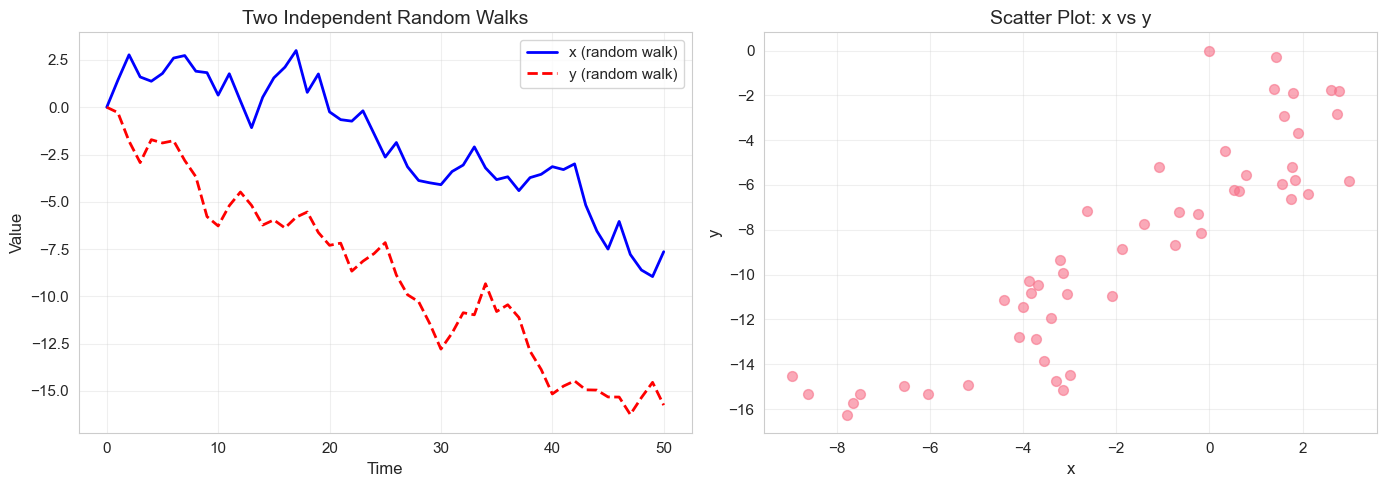


OBSERVATION:
YES Both series wander randomly (unit roots)
YES They may appear to move together by chance


In [12]:
print("\n18.3 SPURIOUS REGRESSION")
print("=" * 70)
print("\nDEMONSTRATION: Two independent random walks can appear related!")

# Set seed for reproducibility
np.random.seed(123456)

# Generate two INDEPENDENT random walks
n = 51
e = stats.norm.rvs(0, 1, size=n)
e[0] = 0
a = stats.norm.rvs(0, 1, size=n)
a[0] = 0

# Cumulative sums (random walks)
x = np.cumsum(a)
y = np.cumsum(e)

sim_data = pd.DataFrame({"y": y, "x": x})

print(f"\nGenerated {n} observations of two INDEPENDENT random walks")
print("  x_t = x_{t-1} + a_t, where a_t ~ N(0,1)")
print("  y_t = y_{t-1} + e_t, where e_t ~ N(0,1)")
print("  Cov(a_t, e_t) = 0  -> x and y are UNRELATED")

# Visualize the two series
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Panel A: Time series plot
axes[0].plot(x, "b-", linewidth=2, label="x (random walk)")
axes[0].plot(y, "r--", linewidth=2, label="y (random walk)")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Value")
axes[0].set_title("Two Independent Random Walks")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Panel B: Scatter plot
axes[1].scatter(x, y, alpha=0.6, s=50)
axes[1].set_xlabel("x")
axes[1].set_ylabel("y")
axes[1].set_title("Scatter Plot: x vs y")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nOBSERVATION:")
print("YES Both series wander randomly (unit roots)")
print("YES They may appear to move together by chance")

In [13]:
# Spurious regression
print("\nSPURIOUS REGRESSION: y = alpha + beta*x + e")
print("=" * 70)

spurious_reg = smf.ols(formula="y ~ x", data=sim_data).fit()

table_spurious = pd.DataFrame(
    {
        "Coefficient": spurious_reg.params,
        "Std. Error": spurious_reg.bse,
        "t-statistic": spurious_reg.tvalues,
        "p-value": spurious_reg.pvalues,
    },
)

display(table_spurious.round(4))

print(f"\nR-squared: {spurious_reg.rsquared:.4f}")
print(f"Durbin-Watson: {sm.stats.stattools.durbin_watson(spurious_reg.resid):.4f}")

print("\nSHOCKING RESULT:")
beta_hat = spurious_reg.params["x"]
t_stat = spurious_reg.tvalues["x"]
pval = spurious_reg.pvalues["x"]

if pval < 0.05:
    print(
        f"NO beta_hat = {beta_hat:.4f} appears HIGHLY SIGNIFICANT (t = {t_stat:.2f}, p = {pval:.4f})"
    )
    print("  -> OLS says x and y are related")
    print("  -> But we KNOW they are independent!")
    print("  -> This is SPURIOUS REGRESSION")
else:
    print(f"  beta_hat = {beta_hat:.4f} is not significant (t = {t_stat:.2f}, p = {pval:.4f})")
    print("  -> This particular simulation avoided spurious regression")
    print("  -> But it happens frequently with non-stationary data!")

# Durbin-Watson diagnostic
dw = sm.stats.stattools.durbin_watson(spurious_reg.resid)
if spurious_reg.rsquared > dw:
    print(f"\nNO WARNING: R^2 ({spurious_reg.rsquared:.4f}) > DW ({dw:.4f})")
    print("  -> Granger-Newbold rule suggests spurious regression")


SPURIOUS REGRESSION: y = alpha + beta*x + e


,Coefficient,Std. Error,t-statistic,p-value
Intercept,-6.5100,0.3465,-18.7894,0.0
x,1.2695,0.0929,13.6607,0.0



R-squared: 0.7920
Durbin-Watson: 0.5931

SHOCKING RESULT:
NO beta_hat = 1.2695 appears HIGHLY SIGNIFICANT (t = 13.66, p = 0.0000)
  -> OLS says x and y are related
  -> But we KNOW they are independent!
  -> This is SPURIOUS REGRESSION

NO WARNING: R^2 (0.7920) > DW (0.5931)
  -> Granger-Newbold rule suggests spurious regression


In [14]:
# Test residuals for unit root
print("\n\nTESTING RESIDUALS FOR UNIT ROOT")
print("=" * 70)
print("If residuals have unit root -> spurious regression")

adf_resid = adfuller(spurious_reg.resid.dropna(), maxlag=1, regression="c")

print(f"\nADF statistic on residuals: {adf_resid[0]:.4f}")
print(f"p-value: {adf_resid[1]:.4f}")
print(f"Critical value (5%): {adf_resid[4]['5%']:.4f}")

if adf_resid[0] > adf_resid[4]["5%"]:
    print("\nNO Residuals have unit root (non-stationary)")
    print("  -> Confirms spurious regression")
    print("  -> Standard inference is invalid!")
else:
    print("\nYES Residuals are stationary")
    print("  -> Not spurious (or cointegrated - see next section)")



TESTING RESIDUALS FOR UNIT ROOT
If residuals have unit root -> spurious regression

ADF statistic on residuals: -4.0660
p-value: 0.0011
Critical value (5%): -2.9214

YES Residuals are stationary
  -> Not spurious (or cointegrated - see next section)


In [15]:
# Correct approach: use first differences
print("\n\nCORRECT APPROACH: First Differences")
print("=" * 70)
print("Model: Deltay_t = beta*Deltax_t + u_t")

# Calculate first differences
sim_data["dy"] = sim_data["y"].diff()
sim_data["dx"] = sim_data["x"].diff()

correct_reg = smf.ols(formula="dy ~ dx", data=sim_data).fit()

table_correct = pd.DataFrame(
    {
        "Coefficient": correct_reg.params,
        "Std. Error": correct_reg.bse,
        "t-statistic": correct_reg.tvalues,
        "p-value": correct_reg.pvalues,
    },
)

display(table_correct.round(4))

print(f"\nR-squared: {correct_reg.rsquared:.4f}")
print(f"Durbin-Watson: {sm.stats.stattools.durbin_watson(correct_reg.resid):.4f}")

print("\nCORRECT INFERENCE:")
beta_diff = correct_reg.params["dx"]
t_diff = correct_reg.tvalues["dx"]
pval_diff = correct_reg.pvalues["dx"]

if pval_diff >= 0.05:
    print(
        f"YES beta_hat = {beta_diff:.4f} is NOT significant (t = {t_diff:.2f}, p = {pval_diff:.4f})"
    )
    print("  -> Correctly finds NO relationship")
    print("  -> First differences avoid spurious regression")
else:
    print(
        f"  beta_hat = {beta_diff:.4f} is significant (t = {t_diff:.2f}, p = {pval_diff:.4f})"
    )
    print("  -> Type I error (but much less likely than with levels)")



CORRECT APPROACH: First Differences
Model: Deltay_t = beta*Deltax_t + u_t


,Coefficient,Std. Error,t-statistic,p-value
Intercept,-0.3266,0.1300,-2.5126,0.0154
dx,-0.0760,0.1249,-0.6083,0.5458



R-squared: 0.0077
Durbin-Watson: 1.9104

CORRECT INFERENCE:
YES beta_hat = -0.0760 is NOT significant (t = -0.61, p = 0.5458)
  -> Correctly finds NO relationship
  -> First differences avoid spurious regression


In [16]:
# Multiple simulations
print("\n\nMULTIPLE SIMULATIONS: Frequency of Spurious Regression")
print("=" * 70)

np.random.seed(42)
n_sims = 1000
significant_count = 0

for _ in range(n_sims):
    # Generate independent random walks
    e_sim = np.cumsum(stats.norm.rvs(0, 1, size=51))
    a_sim = np.cumsum(stats.norm.rvs(0, 1, size=51))

    # Regress
    sim_df = pd.DataFrame({"y": e_sim, "x": a_sim})
    reg_sim = smf.ols(formula="y ~ x", data=sim_df).fit()

    # Check significance
    if reg_sim.pvalues["x"] < 0.05:
        significant_count += 1

spurious_rate = significant_count / n_sims

print(f"\nSimulated {n_sims} pairs of independent random walks")
print("Regressed y on x in each simulation")
print("\nRESULTS:")
print(f"  Significant at 5% level: {significant_count} out of {n_sims}")
print(f"  Spurious regression rate: {100 * spurious_rate:.1f}%")
print("\nEXPECTED if variables were stationary: 5%")
print(f"ACTUAL with non-stationary variables: {100 * spurious_rate:.1f}%")

if spurious_rate > 0.10:
    print("\nNO MUCH higher than 5%!")
    print("  -> Non-stationary variables produce spurious relationships")
    print("  -> ALWAYS test for unit roots before regressing levels")



MULTIPLE SIMULATIONS: Frequency of Spurious Regression



Simulated 1000 pairs of independent random walks
Regressed y on x in each simulation

RESULTS:
  Significant at 5% level: 678 out of 1000
  Spurious regression rate: 67.8%

EXPECTED if variables were stationary: 5%
ACTUAL with non-stationary variables: 67.8%

NO MUCH higher than 5%!
  -> Non-stationary variables produce spurious relationships
  -> ALWAYS test for unit roots before regressing levels


## 18.4 Cointegration and Error Correction Models

**Cointegration** is a special case where two non-stationary I(1) variables have a **stationary linear combination**.

### The Concept

Suppose $y_t$ and $x_t$ are both I(1) (have unit roots). Generally:
- Any linear combination $y_t - \beta x_t$ is also I(1)
- Regression of $y_t$ on $x_t$ is spurious

**BUT** if there exists $\beta$ such that:

$$ y_t - \beta x_t = u_t \quad \text{where } u_t \text{ is I(0) (stationary)} $$

then $y_t$ and $x_t$ are **cointegrated** with cointegrating coefficient $\beta$.

**Economic interpretation**:
- $y_t$ and $x_t$ share a **common stochastic trend**
- They move together in the **long run**
- Deviations from equilibrium ($u_t$) are temporary
- There's a genuine **long-run relationship**, not spurious!

### Testing for Cointegration

**Engle-Granger two-step procedure**:

1. **Step 1**: Regress $y_t$ on $x_t$ (cointegrating regression)
   $$ y_t = \alpha + \beta x_t + u_t $$
   Save residuals $\hat{u}_t = y_t - \hat{\alpha} - \hat{\beta} x_t$

2. **Step 2**: Test if $\hat{u}_t$ is stationary using ADF test
   - $H_0$: No cointegration ($\hat{u}_t$ has unit root)
   - $H_1$: Cointegration ($\hat{u}_t$ is stationary)
   - Use special **Engle-Granger critical values** (more negative than standard ADF)

**Alternative**: Use `coint` function which performs both steps.

### Error Correction Model (ECM)

If $y_t$ and $x_t$ are cointegrated, we can estimate an **error correction model**:

$$ \Delta y_t = \gamma + \theta_1 \Delta x_t + \theta_2 (y_{t-1} - \beta x_{t-1}) + \text{error} $$

or equivalently:

$$ \Delta y_t = \gamma + \theta_1 \Delta x_t + \theta_2 \hat{u}_{t-1} + \text{error} $$

where $\hat{u}_{t-1}$ is the lagged residual from the cointegrating regression.

**Interpretation**:
- $\theta_1$: **Short-run effect** of $\Delta x_t$ on $\Delta y_t$
- $\theta_2$: **Error correction coefficient** (should be negative)
  - If $y_{t-1} > \beta x_{t-1}$ (above equilibrium), then $\Delta y_t$ should decrease
  - Speed of adjustment back to equilibrium
- $\beta$: **Long-run effect** from cointegrating regression

**Key advantage**: ECM is estimated in **first differences** (stationary) but includes **levels information** through error correction term.

### Example: Cointegration Test (Conceptual)

In [17]:
print("\n18.4 COINTEGRATION AND ERROR CORRECTION MODELS")
print("=" * 70)

print("\nCONCEPT: Cointegration")
print("Two I(1) variables can have a stationary linear combination")

print("\nEXAMPLE: Consumption and Income")
print("  - Both consumption (C) and income (Y) are I(1)")
print("  - But C_t - beta*Y_t might be stationary")
print("  - Economic theory: long-run consumption proportional to income")
print("  - Deviations from this relationship are temporary")

print("\nKEY DIFFERENCE FROM SPURIOUS REGRESSION:")
print("  Spurious: y and x are unrelated, just both trending")
print("  Cointegration: y and x share a common trend (genuine relationship)")

print("\nTESTING PROCEDURE:")
print("  1. Confirm both y and x are I(1) (unit root tests)")
print("  2. Regress y_t on x_t -> get residuals u_hat_t")
print("  3. Test if u_hat_t is stationary (ADF test)")
print("  4. If stationary -> cointegrated (long-run relationship exists)")
print("  5. Estimate error correction model (ECM)")


18.4 COINTEGRATION AND ERROR CORRECTION MODELS

CONCEPT: Cointegration
Two I(1) variables can have a stationary linear combination

EXAMPLE: Consumption and Income
  - Both consumption (C) and income (Y) are I(1)
  - But C_t - beta*Y_t might be stationary
  - Economic theory: long-run consumption proportional to income
  - Deviations from this relationship are temporary

KEY DIFFERENCE FROM SPURIOUS REGRESSION:
  Spurious: y and x are unrelated, just both trending
  Cointegration: y and x share a common trend (genuine relationship)

TESTING PROCEDURE:
  1. Confirm both y and x are I(1) (unit root tests)
  2. Regress y_t on x_t -> get residuals u_hat_t
  3. Test if u_hat_t is stationary (ADF test)
  4. If stationary -> cointegrated (long-run relationship exists)
  5. Estimate error correction model (ECM)




SIMULATION: Cointegrated Variables


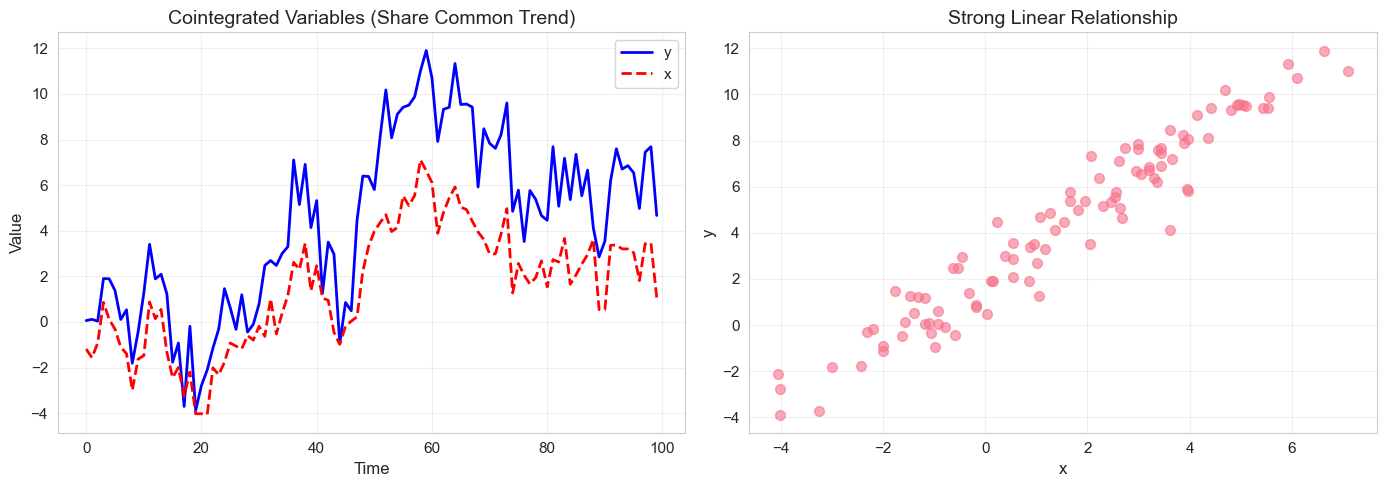


OBSERVATION:
YES Both variables trend upward (unit roots)
YES They move together (share common trend)
YES Unlike spurious regression, this is a REAL relationship


In [18]:
# Simulation: Cointegrated variables
print("\n\nSIMULATION: Cointegrated Variables")
print("=" * 70)

np.random.seed(789)
n = 100

# Generate common stochastic trend
trend = np.cumsum(stats.norm.rvs(0, 1, size=n))

# Two variables sharing this trend, plus stationary deviations
x_coint = trend + stats.norm.rvs(0, 0.5, size=n)
y_coint = 2 + 1.5 * trend + stats.norm.rvs(0, 0.5, size=n)

coint_data = pd.DataFrame({"y": y_coint, "x": x_coint})

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Panel A: Time series
axes[0].plot(y_coint, "b-", linewidth=2, label="y")
axes[0].plot(x_coint, "r--", linewidth=2, label="x")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Value")
axes[0].set_title("Cointegrated Variables (Share Common Trend)")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Panel B: Scatter
axes[1].scatter(x_coint, y_coint, alpha=0.6, s=50)
axes[1].set_xlabel("x")
axes[1].set_ylabel("y")
axes[1].set_title("Strong Linear Relationship")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nOBSERVATION:")
print("YES Both variables trend upward (unit roots)")
print("YES They move together (share common trend)")
print("YES Unlike spurious regression, this is a REAL relationship")

In [19]:
# Step 1: Cointegrating regression
print("\nSTEP 1: Cointegrating Regression")
print("=" * 70)
print("Regress: y_t = alpha + beta*x_t + u_t")

coint_reg = smf.ols(formula="y ~ x", data=coint_data).fit()

table_coint = pd.DataFrame(
    {
        "Coefficient": coint_reg.params,
        "Std. Error": coint_reg.bse,
        "t-statistic": coint_reg.tvalues,
        "p-value": coint_reg.pvalues,
    },
)

display(table_coint.round(4))

print(f"\nR-squared: {coint_reg.rsquared:.4f}")

print("\nLONG-RUN RELATIONSHIP:")
beta_coint = coint_reg.params["x"]
print(f"  beta_hat = {beta_coint:.4f}")
print(f"  -> Long-run: y ~= {coint_reg.params['Intercept']:.2f} + {beta_coint:.2f}*x")

# Save residuals
coint_data["resid"] = coint_reg.resid


STEP 1: Cointegrating Regression
Regress: y_t = alpha + beta*x_t + u_t


,Coefficient,Std. Error,t-statistic,p-value
Intercept,2.1867,0.1161,18.8421,0.0
x,1.4170,0.0385,36.8400,0.0



R-squared: 0.9327

LONG-RUN RELATIONSHIP:
  beta_hat = 1.4170
  -> Long-run: y ~= 2.19 + 1.42*x


In [20]:
# Step 2: Test residuals for stationarity
print("\nSTEP 2: Test Residuals for Stationarity (ADF Test)")
print("=" * 70)
print("H_0: No cointegration (residuals have unit root)")
print("H_1: Cointegration (residuals are stationary)")

adf_coint = adfuller(coint_data["resid"].dropna(), maxlag=1, regression="c")

print(f"\nADF statistic: {adf_coint[0]:.4f}")
print(f"p-value: {adf_coint[1]:.4f}")
print(f"Critical value (5%): {adf_coint[4]['5%']:.4f}")

# Note: Should use Engle-Granger critical values in practice
# Standard ADF critical values are too conservative for cointegration test

if adf_coint[0] < adf_coint[4]["5%"]:
    print("\nYES Residuals are stationary")
    print("  -> REJECT H_0: Variables are COINTEGRATED")
    print("  -> Long-run relationship is genuine, not spurious")
else:
    print("\nNO Residuals have unit root")
    print("  -> FAIL TO REJECT H_0: Variables are NOT cointegrated")
    print("  -> Relationship may be spurious")


STEP 2: Test Residuals for Stationarity (ADF Test)
H_0: No cointegration (residuals have unit root)
H_1: Cointegration (residuals are stationary)

ADF statistic: -10.0789
p-value: 0.0000
Critical value (5%): -2.8912

YES Residuals are stationary
  -> REJECT H_0: Variables are COINTEGRATED
  -> Long-run relationship is genuine, not spurious


In [21]:
# Alternative: Using coint function
print("\n\nALTERNATIVE: Using statsmodels coint() function")
print("=" * 70)

coint_test = coint(coint_data["y"], coint_data["x"])
coint_stat = coint_test[0]
coint_pval = coint_test[1]
coint_crit = coint_test[2]

print(f"Cointegration test statistic: {coint_stat:.4f}")
print(f"p-value: {coint_pval:.4f}")
print(f"Critical values: {coint_crit}")

if coint_pval < 0.05:
    print("\nYES p-value < 0.05 -> COINTEGRATED")
    print("  -> Can estimate error correction model")
else:
    print("\nNO p-value >= 0.05 -> NOT cointegrated")
    print("  -> Use first differences instead")



ALTERNATIVE: Using statsmodels coint() function
Cointegration test statistic: -7.9750
p-value: 0.0000
Critical values: [-4.01048603 -3.39854434 -3.08756793]

YES p-value < 0.05 -> COINTEGRATED
  -> Can estimate error correction model


In [22]:
# Error Correction Model (ECM)
print("\n\nERROR CORRECTION MODEL (ECM)")
print("=" * 70)
print("Model: Deltay_t = gamma + theta_1*Deltax_t + theta_2*u_hat_{t-1} + error")
print("where u_hat_{t-1} = y_{t-1} - beta_hat*x_{t-1} (lagged residual)")

# Create variables for ECM
coint_data["dy"] = coint_data["y"].diff()
coint_data["dx"] = coint_data["x"].diff()
coint_data["resid_lag1"] = coint_data["resid"].shift(1)

# Estimate ECM
ecm = smf.ols(formula="dy ~ dx + resid_lag1", data=coint_data).fit()

table_ecm = pd.DataFrame(
    {
        "Coefficient": ecm.params,
        "Std. Error": ecm.bse,
        "t-statistic": ecm.tvalues,
        "p-value": ecm.pvalues,
    },
)

display(table_ecm.round(4))

print(f"\nR-squared: {ecm.rsquared:.4f}")

print("\nINTERPRETATION:")
theta_1 = ecm.params["dx"]
theta_2 = ecm.params["resid_lag1"]

print(f"  theta_1 (short-run effect): {theta_1:.4f}")
print("    -> Immediate impact of Deltax on Deltay")

print(f"\n  theta_2 (error correction): {theta_2:.4f}")
if theta_2 < 0:
    print("    YES Negative (as expected)")
    print("    -> If y_{t-1} > beta_hat*x_{t-1} (above equilibrium), Deltay_t decreases")
    print(
        f"    -> Adjustment speed: {abs(theta_2):.1%} of deviation corrected per period"
    )
else:
    print("    NO Positive (unexpected)")
    print("    -> May indicate misspecification")

print(f"\n  Long-run effect: beta_hat = {beta_coint:.4f}")
print("    -> From cointegrating regression")
print(f"    -> Permanent 1-unit increase in x -> {beta_coint:.2f}-unit increase in y")



ERROR CORRECTION MODEL (ECM)
Model: Deltay_t = gamma + theta_1*Deltax_t + theta_2*u_hat_{t-1} + error
where u_hat_{t-1} = y_{t-1} - beta_hat*x_{t-1} (lagged residual)


,Coefficient,Std. Error,t-statistic,p-value
Intercept,0.0074,0.1007,0.0739,0.9412
dx,1.2911,0.0913,14.1424,0.0000
resid_lag1,-0.9916,0.1046,-9.4813,0.0000



R-squared: 0.7131

INTERPRETATION:
  theta_1 (short-run effect): 1.2911
    -> Immediate impact of Deltax on Deltay

  theta_2 (error correction): -0.9916
    YES Negative (as expected)
    -> If y_{t-1} > beta_hat*x_{t-1} (above equilibrium), Deltay_t decreases
    -> Adjustment speed: 99.2% of deviation corrected per period

  Long-run effect: beta_hat = 1.4170
    -> From cointegrating regression
    -> Permanent 1-unit increase in x -> 1.42-unit increase in y


## 18.5 Forecasting

**Forecasting** is a key application of time series regression. We use historical data to predict future values.

### Types of Forecasts

**1. One-step-ahead forecast** ($h=1$):
$$ \hat{y}_{T+1} = \hat{\alpha} + \hat{\beta}_1 y_T + \hat{\beta}_2 x_T $$

**2. Multi-step-ahead forecast** ($h>1$):
- Use predicted values to forecast further ahead
- Example: $\hat{y}_{T+2} = \hat{\alpha} + \hat{\beta}_1 \hat{y}_{T+1} + \hat{\beta}_2 x_{T+1}$

### Forecast Errors and Evaluation

**Forecast error**: $e_{T+h} = y_{T+h} - \hat{y}_{T+h}$

**Evaluation metrics**:
- **RMSE** (Root Mean Squared Error): $\text{RMSE} = \sqrt{\frac{1}{m} \sum_{h=1}^{m} e_{T+h}^2}$
  - Penalizes large errors more heavily
  - Same units as $y$

- **MAE** (Mean Absolute Error): $\text{MAE} = \frac{1}{m} \sum_{h=1}^{m} |e_{T+h}|$
  - Treats all errors equally
  - Same units as $y$
  - More robust to outliers

**Lower is better** for both metrics.

### Forecast Intervals

**Point forecast**: $\hat{y}_{T+h}$

**95% forecast interval**:
$$ \hat{y}_{T+h} \pm 1.96 \times SE(\hat{y}_{T+h}) $$

where $SE(\hat{y}_{T+h})$ accounts for:
- Parameter uncertainty (estimation error)
- Innovation uncertainty (future shocks)

**Interpretation**: We're 95% confident the actual value will fall in this range.

### Example 18-8: Forecasting Unemployment

**Goal**: Forecast unemployment rate using past unemployment (AR model) and compare with model that includes inflation.

**Data**: `phillips` - Annual US data 1948-2003
- `unem`: Unemployment rate
- `inf`: Inflation rate

**Estimation period**: 1948-1996 (49 observations)
**Forecast period**: 1997-2003 (7 years out-of-sample)

**Two models**:
1. **AR(1)**: $\text{unem}_t = \alpha + \beta_1 \text{unem}_{t-1} + u_t$
2. **ARX**: $\text{unem}_t = \alpha + \beta_1 \text{unem}_{t-1} + \beta_2 \text{inf}_{t-1} + u_t$

In [23]:
print("\n18.5 FORECASTING")
print("=" * 70)
print("\nEXAMPLE 18-8: Forecasting Unemployment Rate")

# Load data
phillips = wool.data("phillips")

print(f"\nTotal observations: {len(phillips)}")
print("Time period: 1948-2003 (annual data)")
print("\nVARIABLES:")
print("  unem   = Unemployment rate (%)")
print("  inf    = Inflation rate (%)")
print("  unem_1 = Lagged unemployment")
print("  inf_1  = Lagged inflation")

# Create time index
phillips.index = pd.date_range(start="1948", periods=len(phillips), freq="YE").year

# Sample split
train_mask = phillips["year"] <= 1996
test_mask = phillips["year"] > 1996

print(f"\nESTIMATION PERIOD: 1948-1996 ({train_mask.sum()} observations)")
print(f"FORECAST PERIOD:   1997-2003 ({test_mask.sum()} observations)")

# Display summary statistics
print("\nSUMMARY STATISTICS (Full sample):")
display(phillips[["unem", "inf", "unem_1", "inf_1"]].describe().round(2))


18.5 FORECASTING

EXAMPLE 18-8: Forecasting Unemployment Rate



Total observations: 56
Time period: 1948-2003 (annual data)

VARIABLES:
  unem   = Unemployment rate (%)
  inf    = Inflation rate (%)
  unem_1 = Lagged unemployment
  inf_1  = Lagged inflation

ESTIMATION PERIOD: 1948-1996 (49 observations)
FORECAST PERIOD:   1997-2003 (7 observations)

SUMMARY STATISTICS (Full sample):


,unem,inf,unem_1,inf_1
count,56.00,56.00,55.00,55.00
mean,5.63,3.88,5.63,3.91
std,1.51,3.04,1.52,3.06
min,2.90,-1.20,2.90,-1.20
25%,4.50,1.68,4.50,1.65
50%,5.55,3.05,5.50,3.10
75%,6.72,5.43,6.75,5.45
max,9.70,13.50,9.70,13.50


In [24]:
# Model 1: AR(1) without inflation
print("\nMODEL 1: AR(1) - Unemployment Only")
print("=" * 70)
print("Specification: unem_t = alpha + beta_1*unem_{t-1} + u_t")

model_1 = smf.ols(formula="unem ~ unem_1", data=phillips[train_mask]).fit()

table_1 = pd.DataFrame(
    {
        "Coefficient": model_1.params,
        "Std. Error": model_1.bse,
        "t-statistic": model_1.tvalues,
        "p-value": model_1.pvalues,
    },
)

display(table_1.round(4))

print(f"\nR-squared: {model_1.rsquared:.4f}")
print(f"Adj. R-squared: {model_1.rsquared_adj:.4f}")

print("\nINTERPRETATION:")
beta_1 = model_1.params["unem_1"]
print(f"  beta_hat_1 = {beta_1:.4f}")
if 0 < beta_1 < 1:
    print("  -> Unemployment is persistent (0 < beta_1 < 1)")
    print("  -> High unemployment today -> high unemployment tomorrow")
    print("  -> But mean-reverting (beta_1 < 1)")


MODEL 1: AR(1) - Unemployment Only
Specification: unem_t = alpha + beta_1*unem_{t-1} + u_t


,Coefficient,Std. Error,t-statistic,p-value
Intercept,1.5717,0.5771,2.7234,0.0091
unem_1,0.7324,0.0969,7.5586,0.0000



R-squared: 0.5540
Adj. R-squared: 0.5443

INTERPRETATION:
  beta_hat_1 = 0.7324
  -> Unemployment is persistent (0 < beta_1 < 1)
  -> High unemployment today -> high unemployment tomorrow
  -> But mean-reverting (beta_1 < 1)


In [25]:
# Model 2: ARX with inflation
print("\nMODEL 2: ARX - Unemployment and Inflation")
print("=" * 70)
print("Specification: unem_t = alpha + beta_1*unem_{t-1} + beta_2*inf_{t-1} + u_t")

model_2 = smf.ols(formula="unem ~ unem_1 + inf_1", data=phillips[train_mask]).fit()

table_2 = pd.DataFrame(
    {
        "Coefficient": model_2.params,
        "Std. Error": model_2.bse,
        "t-statistic": model_2.tvalues,
        "p-value": model_2.pvalues,
    },
)

display(table_2.round(4))

print(f"\nR-squared: {model_2.rsquared:.4f}")
print(f"Adj. R-squared: {model_2.rsquared_adj:.4f}")

print("\nINTERPRETATION:")
beta_inf = model_2.params["inf_1"]
pval_inf = model_2.pvalues["inf_1"]
print(f"  beta_hat_2 (inflation effect): {beta_inf:.4f}")
if pval_inf < 0.05:
    print(f"  YES Statistically significant (p = {pval_inf:.4f})")
    if beta_inf < 0:
        print("  -> Higher inflation -> lower unemployment (Phillips curve)")
    else:
        print("  -> Higher inflation -> higher unemployment")
else:
    print(f"  NO Not statistically significant (p = {pval_inf:.4f})")
    print("  -> Inflation may not help forecast unemployment")

# Compare models
print("\nMODEL COMPARISON:")
print(f"  Model 1 (AR only):  R^2 = {model_1.rsquared:.4f}")
print(f"  Model 2 (with inf): R^2 = {model_2.rsquared:.4f}")
if model_2.rsquared > model_1.rsquared:
    print("  -> Model 2 fits better in-sample")
else:
    print("  -> Model 1 fits better in-sample")


MODEL 2: ARX - Unemployment and Inflation
Specification: unem_t = alpha + beta_1*unem_{t-1} + beta_2*inf_{t-1} + u_t


,Coefficient,Std. Error,t-statistic,p-value
Intercept,1.3038,0.4897,2.6625,0.0107
unem_1,0.6470,0.0838,7.7206,0.0000
inf_1,0.1836,0.0412,4.4576,0.0001



R-squared: 0.6906
Adj. R-squared: 0.6768

INTERPRETATION:
  beta_hat_2 (inflation effect): 0.1836
  YES Statistically significant (p = 0.0001)
  -> Higher inflation -> higher unemployment

MODEL COMPARISON:
  Model 1 (AR only):  R^2 = 0.5540
  Model 2 (with inf): R^2 = 0.6906
  -> Model 2 fits better in-sample


In [26]:
# Forecasts with 95% intervals
print("\nOUT-OF-SAMPLE FORECASTS: 1997-2003")
print("=" * 70)

# Model 1 forecasts
pred_1 = model_1.get_prediction(phillips[test_mask])
pred_1_df = pred_1.summary_frame(alpha=0.05)[["mean", "obs_ci_lower", "obs_ci_upper"]]
pred_1_df.index = phillips[test_mask].index
pred_1_df.columns = ["Forecast", "Lower 95%", "Upper 95%"]

print("\nMODEL 1 FORECASTS (AR only):")
pred_1_display = pred_1_df.copy()
pred_1_display["Actual"] = phillips.loc[test_mask, "unem"].values
pred_1_display["Error"] = pred_1_display["Actual"] - pred_1_display["Forecast"]
display(pred_1_display.round(2))

# Model 2 forecasts
pred_2 = model_2.get_prediction(phillips[test_mask])
pred_2_df = pred_2.summary_frame(alpha=0.05)[["mean", "obs_ci_lower", "obs_ci_upper"]]
pred_2_df.index = phillips[test_mask].index
pred_2_df.columns = ["Forecast", "Lower 95%", "Upper 95%"]

print("\nMODEL 2 FORECASTS (with inflation):")
pred_2_display = pred_2_df.copy()
pred_2_display["Actual"] = phillips.loc[test_mask, "unem"].values
pred_2_display["Error"] = pred_2_display["Actual"] - pred_2_display["Forecast"]
display(pred_2_display.round(2))


OUT-OF-SAMPLE FORECASTS: 1997-2003

MODEL 1 FORECASTS (AR only):


,Forecast,Lower 95%,Upper 95%,Actual,Error
1997,5.53,3.39,7.66,4.9,-0.63
1998,5.16,3.02,7.30,4.5,-0.66
1999,4.87,2.72,7.01,4.2,-0.67
2000,4.65,2.49,6.80,4.0,-0.65
2001,4.50,2.34,6.66,4.8,0.30
2002,5.09,2.95,7.23,5.8,0.71
2003,5.82,3.69,7.95,6.0,0.18



MODEL 2 FORECASTS (with inflation):


,Forecast,Lower 95%,Upper 95%,Actual,Error
1997,5.35,3.55,7.15,4.9,-0.45
1998,4.90,3.09,6.70,4.5,-0.40
1999,4.51,2.69,6.32,4.2,-0.31
2000,4.43,2.61,6.24,4.0,-0.43
2001,4.52,2.70,6.34,4.8,0.28
2002,4.92,3.12,6.73,5.8,0.88
2003,5.35,3.54,7.16,6.0,0.65


In [27]:
# Forecast evaluation
print("\nFORECAST EVALUATION")
print("=" * 70)

# Calculate forecast errors
e1 = phillips.loc[test_mask, "unem"].values - pred_1_df["Forecast"].values
e2 = phillips.loc[test_mask, "unem"].values - pred_2_df["Forecast"].values

# RMSE
rmse_1 = np.sqrt(np.mean(e1**2))
rmse_2 = np.sqrt(np.mean(e2**2))

print("\nROOT MEAN SQUARED ERROR (RMSE):")
print(f"  Model 1 (AR only):  {rmse_1:.4f}")
print(f"  Model 2 (with inf): {rmse_2:.4f}")

if rmse_1 < rmse_2:
    improvement = ((rmse_2 - rmse_1) / rmse_2) * 100
    print(f"  YES Model 1 is better (RMSE {improvement:.1f}% lower)")
else:
    improvement = ((rmse_1 - rmse_2) / rmse_1) * 100
    print(f"  YES Model 2 is better (RMSE {improvement:.1f}% lower)")

# MAE
mae_1 = np.mean(np.abs(e1))
mae_2 = np.mean(np.abs(e2))

print("\nMEAN ABSOLUTE ERROR (MAE):")
print(f"  Model 1 (AR only):  {mae_1:.4f}")
print(f"  Model 2 (with inf): {mae_2:.4f}")

if mae_1 < mae_2:
    improvement = ((mae_2 - mae_1) / mae_2) * 100
    print(f"  YES Model 1 is better (MAE {improvement:.1f}% lower)")
else:
    improvement = ((mae_1 - mae_2) / mae_1) * 100
    print(f"  YES Model 2 is better (MAE {improvement:.1f}% lower)")

print("\nKEY INSIGHT:")
if rmse_1 < rmse_2 and mae_1 < mae_2:
    print("  -> Simple AR(1) model forecasts better than model with inflation")
    print("  -> Adding inflation does not improve out-of-sample forecasts")
    print("  -> Simpler model preferred (parsimony principle)")
elif rmse_2 < rmse_1 and mae_2 < mae_1:
    print("  -> Model with inflation forecasts better")
    print("  -> Inflation provides useful information for forecasting unemployment")
else:
    print("  -> Mixed results: one metric favors Model 1, another favors Model 2")
    print("  -> Consider context and forecast horizon")


FORECAST EVALUATION

ROOT MEAN SQUARED ERROR (RMSE):
  Model 1 (AR only):  0.5761
  Model 2 (with inf): 0.5218
  YES Model 2 is better (RMSE 9.4% lower)

MEAN ABSOLUTE ERROR (MAE):
  Model 1 (AR only):  0.5420
  Model 2 (with inf): 0.4842
  YES Model 2 is better (MAE 10.7% lower)

KEY INSIGHT:
  -> Model with inflation forecasts better
  -> Inflation provides useful information for forecasting unemployment



VISUALIZATION: Forecasts vs Actual


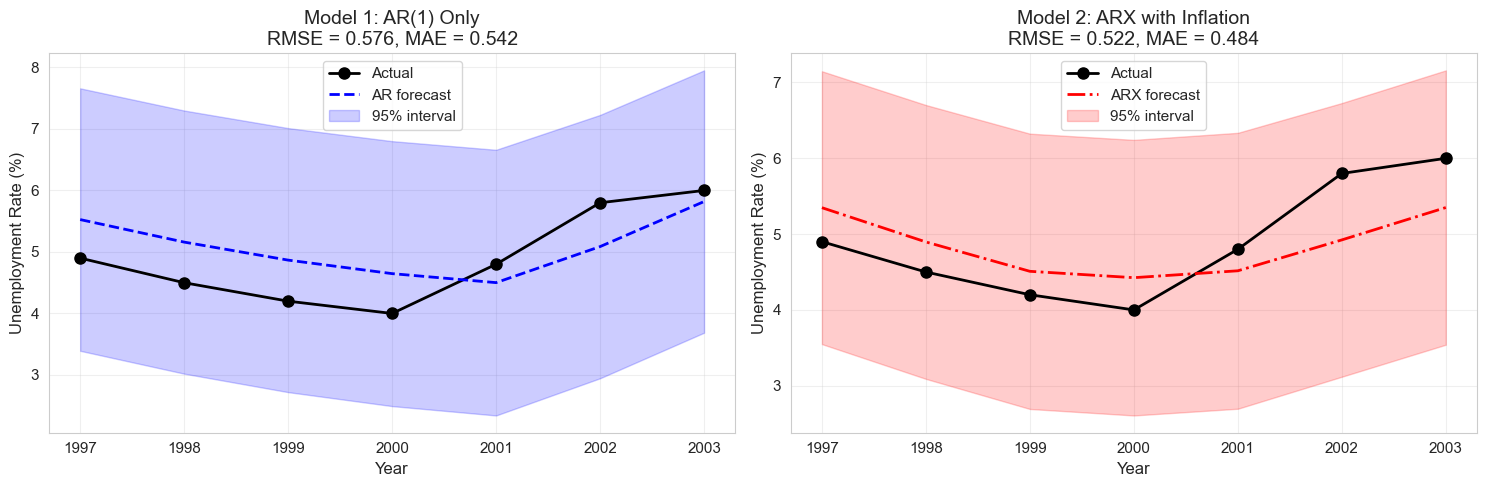


OBSERVATIONS:
YES Forecast intervals widen for multi-step forecasts (cumulative uncertainty)
YES Both models track the general trend
YES Actual unemployment sometimes falls outside forecast intervals
  -> Unexpected shocks (recessions, policy changes)


In [28]:
# Visualization
print("\nVISUALIZATION: Forecasts vs Actual")

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Panel A: Model 1
actual = phillips.loc[test_mask, "unem"]
axes[0].plot(
    actual.index, actual.values, "ko-", linewidth=2, markersize=8, label="Actual"
)
axes[0].plot(
    pred_1_df.index,
    pred_1_df["Forecast"],
    "b--",
    linewidth=2,
    label="AR forecast",
)
axes[0].fill_between(
    pred_1_df.index,
    pred_1_df["Lower 95%"],
    pred_1_df["Upper 95%"],
    alpha=0.2,
    color="blue",
    label="95% interval",
)
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Unemployment Rate (%)")
axes[0].set_title(f"Model 1: AR(1) Only\nRMSE = {rmse_1:.3f}, MAE = {mae_1:.3f}")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Panel B: Model 2
axes[1].plot(
    actual.index, actual.values, "ko-", linewidth=2, markersize=8, label="Actual"
)
axes[1].plot(
    pred_2_df.index,
    pred_2_df["Forecast"],
    "r-.",
    linewidth=2,
    label="ARX forecast",
)
axes[1].fill_between(
    pred_2_df.index,
    pred_2_df["Lower 95%"],
    pred_2_df["Upper 95%"],
    alpha=0.2,
    color="red",
    label="95% interval",
)
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Unemployment Rate (%)")
axes[1].set_title(
    f"Model 2: ARX with Inflation\nRMSE = {rmse_2:.3f}, MAE = {mae_2:.3f}"
)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nOBSERVATIONS:")
print("YES Forecast intervals widen for multi-step forecasts (cumulative uncertainty)")
print("YES Both models track the general trend")
print("YES Actual unemployment sometimes falls outside forecast intervals")
print("  -> Unexpected shocks (recessions, policy changes)")

## 18.6 Event Studies with Control Groups

**Event studies** analyze the causal effect of a specific event (policy change, natural disaster, etc.) using time series data.

### Difference-in-Differences with Time Series

**Setup**:
- **Treatment group**: Affected by the event at time $T_0$
- **Control group**: Not affected by the event
- **Pre-period**: Before $T_0$
- **Post-period**: After $T_0$

**Model**:
$$ y_{it} = \alpha + \delta_0 D_i + \delta_1 \text{Post}_t + \beta (D_i \times \text{Post}_t) + u_{it} $$

where:
- $D_i = 1$ for treatment group, 0 for control
- $\text{Post}_t = 1$ after event, 0 before
- $\beta$: **Treatment effect** (difference-in-differences estimator)

**Interpretation of coefficients**:
- $\delta_0$: Baseline difference between groups (pre-treatment)
- $\delta_1$: Time trend (affects both groups)
- $\beta$: **Causal effect** of treatment (DD estimator)

**Key assumption**: **Parallel trends**
- Without treatment, both groups would follow similar trends
- Testable in pre-period data

### With Time Series Complications

Time series event studies must account for:
1. **Serial correlation**: Observations over time are correlated
2. **Trends**: Both groups may have trends
3. **Dynamics**: Effects may build up over time
4. **Seasonality**: For high-frequency data

**Extensions**:
- Add lagged dependent variables (dynamic DiD)
- Include group-specific trends
- Use robust standard errors (HAC)

### Example: Conceptual Framework

In [29]:
print("\n18.6 EVENT STUDIES WITH CONTROL GROUPS")
print("=" * 70)

print("\nCONCEPT: Difference-in-Differences with Time Series")
print("\nSETUP:")
print("  - Treatment group: Affected by policy/event at time T_0")
print("  - Control group: Not affected")
print("  - Compare trends before and after T_0")

print("\nMODEL:")
print("  y_{it} = alpha + delta_0*Treat_i + delta_1*Post_t + beta*(Treat_i x Post_t) + u_{it}")

print("\nINTERPRETATION:")
print("  alpha: Baseline level (control group, pre-period)")
print("  delta_0: Pre-treatment difference (treatment - control)")
print("  delta_1: Time trend (affects both groups)")
print("  beta: TREATMENT EFFECT (difference-in-differences)")

print("\nKEY ASSUMPTION: Parallel Trends")
print("  -> Without treatment, both groups would follow similar trends")
print("  -> Testable: check if trends are parallel in pre-period")

print("\nEXAMPLE APPLICATIONS:")
print("  * Minimum wage increase in one state (control: neighboring state)")
print("  * Tax policy change in one region")
print("  * Environmental regulation in one industry")
print("  * COVID-19 policy (e.g., lockdowns in some regions)")


18.6 EVENT STUDIES WITH CONTROL GROUPS

CONCEPT: Difference-in-Differences with Time Series

SETUP:
  - Treatment group: Affected by policy/event at time T_0
  - Control group: Not affected
  - Compare trends before and after T_0

MODEL:
  y_{it} = alpha + delta_0*Treat_i + delta_1*Post_t + beta*(Treat_i x Post_t) + u_{it}

INTERPRETATION:
  alpha: Baseline level (control group, pre-period)
  delta_0: Pre-treatment difference (treatment - control)
  delta_1: Time trend (affects both groups)
  beta: TREATMENT EFFECT (difference-in-differences)

KEY ASSUMPTION: Parallel Trends
  -> Without treatment, both groups would follow similar trends
  -> Testable: check if trends are parallel in pre-period

EXAMPLE APPLICATIONS:
  * Minimum wage increase in one state (control: neighboring state)
  * Tax policy change in one region
  * Environmental regulation in one industry
  * COVID-19 policy (e.g., lockdowns in some regions)


In [30]:
# Simulation: DiD with Time Series
print("\n\nSIMULATION: Difference-in-Differences Event Study")
print("=" * 70)

np.random.seed(2024)

# Generate data
n_periods = 40  # 20 pre, 20 post
treatment_time = 20

# Control group (never treated)
time = np.arange(1, n_periods + 1)
control = 5 + 0.1 * time + stats.norm.rvs(0, 0.5, size=n_periods)

# Treatment group (treated after period 20)
treatment = 6 + 0.1 * time + stats.norm.rvs(0, 0.5, size=n_periods)
treatment[treatment_time:] += 2  # Treatment effect = 2

# Create DataFrame
# Need to duplicate post indicator for both groups
post_indicator = np.array([0] * treatment_time + [1] * (n_periods - treatment_time))

did_data = pd.DataFrame(
    {
        "time": np.tile(time, 2),
        "group": ["Control"] * n_periods + ["Treatment"] * n_periods,
        "y": np.concatenate([control, treatment]),
        "treat": [0] * n_periods + [1] * n_periods,
        "post": np.tile(post_indicator, 2),
    },
)
did_data["treat_post"] = did_data["treat"] * did_data["post"]

print(f"\nGenerated {n_periods} time periods for 2 groups")
print(f"Treatment occurs at period {treatment_time}")
print("True treatment effect: 2.0")

print("\nDATA STRUCTURE:")
display(did_data.head(10))



SIMULATION: Difference-in-Differences Event Study

Generated 40 time periods for 2 groups
Treatment occurs at period 20
True treatment effect: 2.0

DATA STRUCTURE:


,time,group,y,treat,post,treat_post
0,1,Control,5.934024,0,0,0
1,2,Control,5.568674,0,0,0
2,3,Control,5.199231,0,0,0
3,4,Control,5.324544,0,0,0
4,5,Control,5.958026,0,0,0
5,6,Control,6.180165,0,0,0
6,7,Control,4.390019,0,0,0
7,8,Control,5.137353,0,0,0
8,9,Control,6.129994,0,0,0
9,10,Control,6.051026,0,0,0



VISUALIZATION: Parallel Trends and Treatment Effect


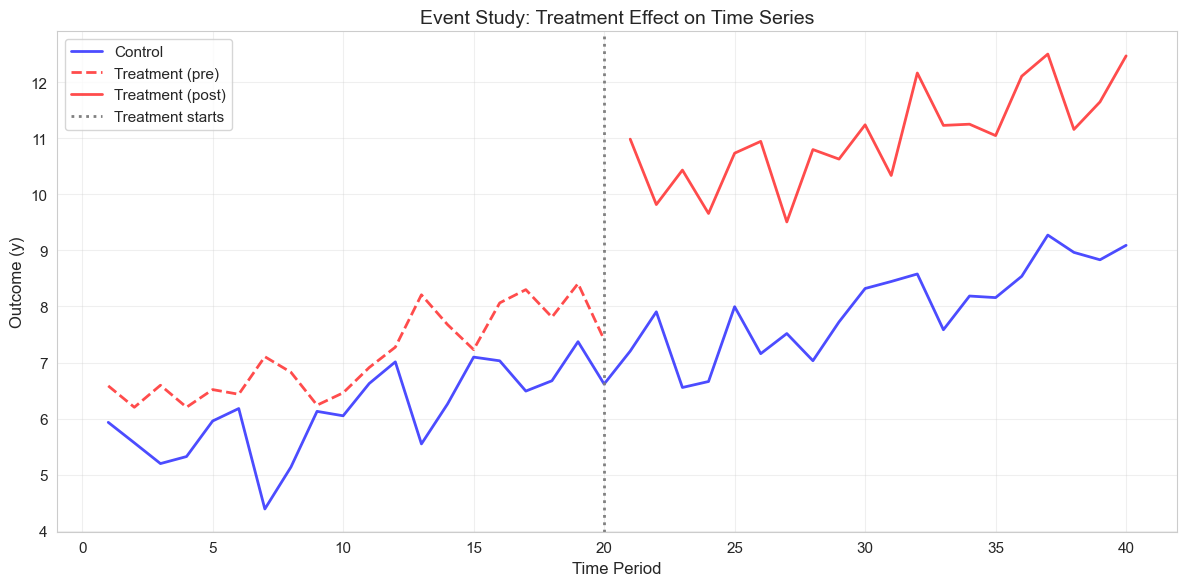


OBSERVATIONS:
YES Pre-treatment: Both groups follow parallel trends
YES Post-treatment: Treatment group jumps up (treatment effect)
  -> Difference-in-differences captures this jump


In [31]:
# Visualize parallel trends
print("\nVISUALIZATION: Parallel Trends and Treatment Effect")

fig, ax = plt.subplots(figsize=(12, 6))

# Control group
control_data = did_data[did_data["group"] == "Control"]
ax.plot(
    control_data["time"],
    control_data["y"],
    "b-",
    linewidth=2,
    label="Control",
    alpha=0.7,
)

# Treatment group
treat_data = did_data[did_data["group"] == "Treatment"]
pre_treat = treat_data[treat_data["time"] <= treatment_time]
post_treat = treat_data[treat_data["time"] > treatment_time]

ax.plot(
    pre_treat["time"],
    pre_treat["y"],
    "r--",
    linewidth=2,
    label="Treatment (pre)",
    alpha=0.7,
)
ax.plot(
    post_treat["time"],
    post_treat["y"],
    "r-",
    linewidth=2,
    label="Treatment (post)",
    alpha=0.7,
)

# Mark treatment time
ax.axvline(
    x=treatment_time, color="gray", linestyle=":", linewidth=2, label="Treatment starts"
)

ax.set_xlabel("Time Period")
ax.set_ylabel("Outcome (y)")
ax.set_title("Event Study: Treatment Effect on Time Series")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nOBSERVATIONS:")
print("YES Pre-treatment: Both groups follow parallel trends")
print("YES Post-treatment: Treatment group jumps up (treatment effect)")
print("  -> Difference-in-differences captures this jump")

In [32]:
# Estimate DiD model
print("\nDIFFERENCE-IN-DIFFERENCES ESTIMATION")
print("=" * 70)
print("Model: y = alpha + delta_0*Treat + delta_1*Post + beta*(Treat x Post) + u")

did_model = smf.ols(formula="y ~ treat + post + treat_post", data=did_data).fit()

table_did = pd.DataFrame(
    {
        "Coefficient": did_model.params,
        "Std. Error": did_model.bse,
        "t-statistic": did_model.tvalues,
        "p-value": did_model.pvalues,
    },
)

display(table_did.round(4))

print(f"\nR-squared: {did_model.rsquared:.4f}")

print("\nINTERPRETATION:")
alpha = did_model.params["Intercept"]
delta_0 = did_model.params["treat"]
delta_1 = did_model.params["post"]
beta_dd = did_model.params["treat_post"]

print(f"  alpha_hat (baseline): {alpha:.4f}")
print("    -> Control group level in pre-period")

print(f"\n  delta_hat_0 (group difference): {delta_0:.4f}")
print(f"    -> Treatment group {delta_0:.2f} units higher pre-treatment")

print(f"\n  delta_hat_1 (time trend): {delta_1:.4f}")
print(f"    -> Both groups increase {delta_1:.2f} units in post-period")

print(f"\n  beta_hat (treatment effect): {beta_dd:.4f}")
print("    YES CAUSAL EFFECT of treatment")
print(f"    -> Treatment causes {beta_dd:.2f}-unit increase in outcome")
print(f"    -> True effect = 2.0, estimated = {beta_dd:.2f}")

# Compare to truth
if abs(beta_dd - 2.0) < 0.5:
    print("\nYES Estimated effect close to true effect (2.0)")
else:
    print("\nWARNING Estimated effect differs from true effect (sampling variation)")

print("\nCONCLUSION:")
print("  -> Difference-in-differences successfully identifies treatment effect")
print("  -> Control group accounts for common time trends")
print("  -> Critical assumption: parallel trends (testable in pre-period)")


DIFFERENCE-IN-DIFFERENCES ESTIMATION
Model: y = alpha + delta_0*Treat + delta_1*Post + beta*(Treat x Post) + u


,Coefficient,Std. Error,t-statistic,p-value
Intercept,6.1303,0.1773,34.5850,0.0000
treat,0.9927,0.2507,3.9599,0.0002
post,1.8556,0.2507,7.4027,0.0000
treat_post,2.0520,0.3545,5.7883,0.0000



R-squared: 0.8491

INTERPRETATION:
  alpha_hat (baseline): 6.1303
    -> Control group level in pre-period

  delta_hat_0 (group difference): 0.9927
    -> Treatment group 0.99 units higher pre-treatment

  delta_hat_1 (time trend): 1.8556
    -> Both groups increase 1.86 units in post-period

  beta_hat (treatment effect): 2.0520
    YES CAUSAL EFFECT of treatment
    -> Treatment causes 2.05-unit increase in outcome
    -> True effect = 2.0, estimated = 2.05

YES Estimated effect close to true effect (2.0)

CONCLUSION:
  -> Difference-in-differences successfully identifies treatment effect
  -> Control group accounts for common time trends
  -> Critical assumption: parallel trends (testable in pre-period)


## Summary

This chapter covered advanced time series topics essential for applied econometrics:

1. **Infinite Distributed Lag Models**:
   - Geometric (Koyck) and rational distributed lags
   - Long-run propensity (LRP) calculations
   - Flexible modeling of dynamic effects

2. **Unit Root Testing**:
   - Dickey-Fuller and Augmented Dickey-Fuller (ADF) tests
   - Testing for stationarity vs random walk behavior
   - Critical for avoiding spurious regression

3. **Spurious Regression**:
   - False relationships between non-stationary series
   - Detection: R^2 > DW, non-stationary residuals
   - Solution: First differences or cointegration

4. **Cointegration**:
   - Long-run equilibrium relationships
   - Error correction models (ECM)
   - Combines long-run (levels) and short-run (differences) information

5. **Forecasting**:
   - One-step and multi-step forecasts
   - Forecast evaluation: RMSE, MAE
   - 95% forecast intervals
   - Model comparison for out-of-sample performance

6. **Event Studies**:
   - Difference-in-differences with time series
   - Causal effect identification
   - Parallel trends assumption

### Decision Tree: Time Series Regression

```
Are your variables trending over time?
|- NO -> Standard OLS regression (Chapters 10-12)
|- YES
   |- Test for unit roots (ADF test)
   |  |- Both stationary (I(0))
   |  |  |- -> Use levels in regression
   |  |- At least one non-stationary (I(1))
   |     |- Test for cointegration
   |     |  |- Cointegrated
   |     |  |  |- -> Error correction model (ECM)
   |     |  |- Not cointegrated
   |     |     |- -> Use first differences
   |     |- Forecasting?
   |        |- One-step ahead -> Direct forecast
   |        |- Multi-step -> Iterate forecasts
   |        |- Evaluate: RMSE, MAE, forecast intervals
```

### Key Takeaways

1. **Always test for unit roots** before regressing trending variables
2. **Spurious regression is a real danger** with non-stationary data
3. **Cointegration** allows using levels when a long-run relationship exists
4. **Error correction models** combine long-run and short-run dynamics
5. **Forecasting** requires out-of-sample evaluation (not just R^2)
6. **Event studies** need parallel trends assumption for causal inference

### Best Practices

- Test all time series for unit roots before modeling
- Check residuals for stationarity (avoid spurious regression)
- Use robust standard errors (HAC) for time series inference
- Evaluate forecasts out-of-sample, not just in-sample fit
- Plot data to visualize trends, breaks, and patterns
- Consider economic theory when choosing between levels and differences

**Next steps**: Panel data methods (Chapter 13-14) and limited dependent variables (Chapter 17).
